## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [2]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [6]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SBSSBBBS'
#meas='SNWD'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
502
+------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+-------------------+--------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|           coeff_1|            coeff_2|          coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|               res_2|              res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+------------------+-------------------+-----------------+---------+--------+--------+---------+-----------+-------------------+--------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|-8864.636346120038|-2039.9548861316823|698.3849072461769|   1797.4|SBSSBBBS|  43.465|-113.5581|       SNWD| 0.0848993837998154| 0.03534173056103785|0.03086802364758516|0.74896324

In [7]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00102260|  43.465|-113.5581|   1797.4|-8864.636346120038|
|USC00104845| 43.6842|-114.3603|   1795.3|-6921.010051408701|
|USC00104845| 43.6842|-114.3603|   1795.3| -5862.92682935591|
|USC00104230| 42.9419|-111.4361|   2025.1| -6048.05803651344|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [8]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

station  latitude  longitude  elevation  count(station)  avg(coeff_1)
17  USC00100010   42.9536  -112.8253     1342.6              12     56.867813
2   USC00100227   42.8572  -112.8800     1345.7              10    271.211206

In [9]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [33]:
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
# identify lat and long for dataset givelat = pdf['latitude']
longi = pdf['longitude']

lat_min = lat.min()
lat_max = lat.max()
print lat_min
print lat_max

longi_min = longi.min()
longi_max = longi.max()
print longi_min
print longi_max

# lat_min = 42.6006
# lat_max = 43.75
# longi_min = -114.75
# longi_max = -111.05

min_lat,max_lat,min_long,max_long = box = (lat_min-.2, lat_max+.2, longi_min-.2 ,longi_max+.2 )


42.6042
43.7306
-114.75
-111.05


In [34]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
# you can change 

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(600*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

Widget Javascript not detected.  It may not be installed or enabled properly.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

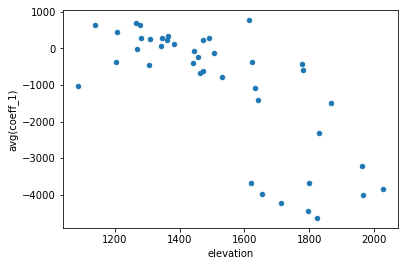

In [15]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [16]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']